# Convolutional Neural Networks: Revisited

Let's improve upon our CNN example in a few ways.

First, we're going to add multiple layers of convolution. The idea is that as we progress through more Conv2D layers, they will learn higher-level features.

In between each layer, we're going to introduce Max Pooling as we discussed. So after our first pass at convolving, we'll do a 2x2 MaxPooling2D layer to reduce our 32x32 images to 16x16. Then, we'll do it again to get us to 8x8, and by the end, we're down to just 4x4 images. This has a good positive impact on performance, since we end up with much less data to process. And, since we're trying to identify higher-level features as we go up the topology, it makes sense to use lower-resolution, less detailed images as we progress up. To prevent overfitting, we also do a Dropout on each layer.

Finally, we stack two Conv2D layers on top of each other within each layer of our topology. This is a trick that allows us to better pick up on non-linear patterns that may exist.


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
    
def createModel(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
     
    return model

We'll prepare our data and visualize it exactly as we did before.

In [17]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(x_train.shape[0])
print(x_test.shape[0])

print (y_test[0])
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print (y_test[0])

(50000, 32, 32, 3)
50000
10000
[3]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


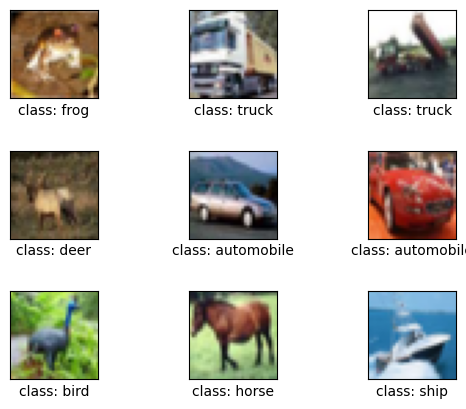

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])

    xlabel = "class: {0}".format(class_names[y_train[i].argmax()])

    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)

    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])


In [19]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Let's compile our more complex CNN, again with RMSprop:

In [21]:
opt = tf.keras.optimizers.RMSprop(lr=0.0001)

model = createModel(x_train.shape[1:])

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        36928     
                                                      

Now let's actually train our neural network, and see how much time it takes for the same 10 epochs we did before:

In [25]:
import time

start_time = time.time()

model.fit(x_train, y_train,
          batch_size=32,
          epochs=1,
          validation_data=(x_test, y_test),
          shuffle=True)

elapsed_time = time.time() - start_time

print(elapsed_time)

1563/1563 [==============================] - 159s 102ms/step - loss: 1.5253 - accuracy: 0.4453 - val_loss: 1.3036 - val_accuracy: 0.5263
159.51786613464355


Well, that's interesting - even though this model is much more complex, it ran in about half the time. Is it also more accurate?

In [26]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 7s 21ms/step - loss: 1.3036 - accuracy: 0.5263
Test loss: 1.3036279678344727
Test accuracy: 0.5263000130653381


It is! Our original CNN achieved 60% accuracy, and we're up to 63% now - even with all those MaxPooling layers that *removed* quite a bit of information along the way. So, with MaxPooling2D we sped up our processing considerably - and by improving our topology, we didn't have to pay a price in accuracy or speed of convergence.

What's really nice is that our faster model means we can run more epochs, and get better accuracy, in a reasonable amount of time. Let's let it go for 50 epochs and see how good accuracy gets.

In [9]:
start_time = time.time()

model.fit(x_train, y_train,
          batch_size=32,
          epochs=50,
          validation_data=(x_test, y_test),
          shuffle=True)

elapsed_time = time.time() - start_time

print(elapsed_time)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 208us/step - loss: 1.0337 - acc: 0.6321 - val_loss: 0.9409 - val_acc: 0.6647
Epoch 2/50
50000/50000 [==============================] - 11s 215us/step - loss: 1.0033 - acc: 0.6424 - val_loss: 0.9341 - val_acc: 0.6668
Epoch 3/50
50000/50000 [==============================] - 11s 222us/step - loss: 0.9714 - acc: 0.6563 - val_loss: 0.9496 - val_acc: 0.6577
Epoch 4/50
50000/50000 [==============================] - 11s 222us/step - loss: 0.9446 - acc: 0.6666 - val_loss: 0.8802 - val_acc: 0.6867
Epoch 5/50
50000/50000 [==============================] - 11s 213us/step - loss: 0.9217 - acc: 0.6728 - val_loss: 0.9120 - val_acc: 0.6797
Epoch 6/50
50000/50000 [==============================] - 11s 211us/step - loss: 0.9044 - acc: 0.6788 - val_loss: 0.8506 - val_acc: 0.6999
Epoch 7/50
50000/50000 [==============================] - 10s 209us/step - loss: 0.8803 - acc: 0.6889 - val_loss: 0.

In [10]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 67us/step
Test loss: 0.6638496156215667
Test accuracy: 0.7815


Much better! Let's take a look at some examples of where it went wrong, and see if they're more forgivable to our human minds:

1/1 [==============================] - 0s 403ms/step


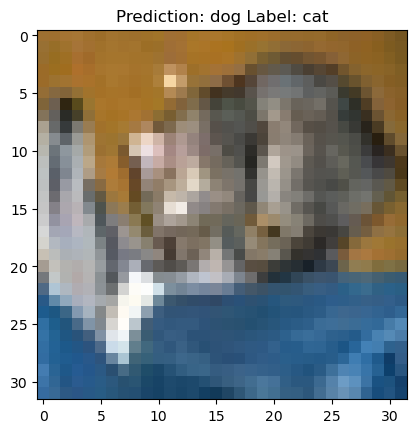

1/1 [==============================] - 0s 25ms/step


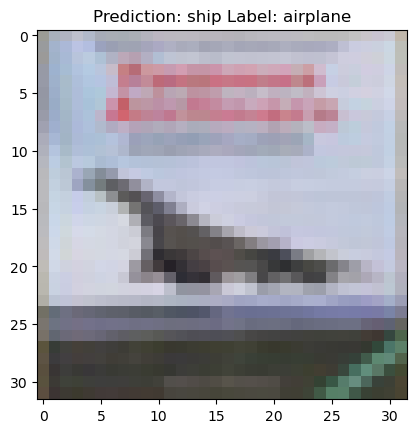

1/1 [==============================] - 0s 28ms/step


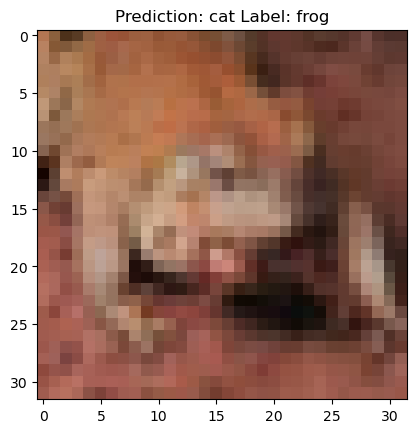

1/1 [==============================] - 0s 35ms/step


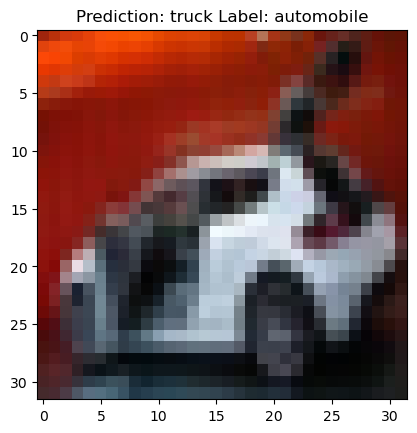

1/1 [==============================] - 0s 27ms/step


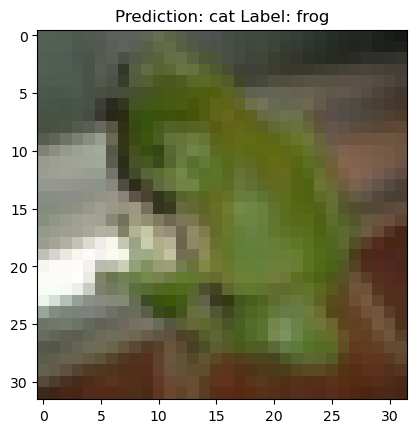

1/1 [==============================] - 0s 26ms/step


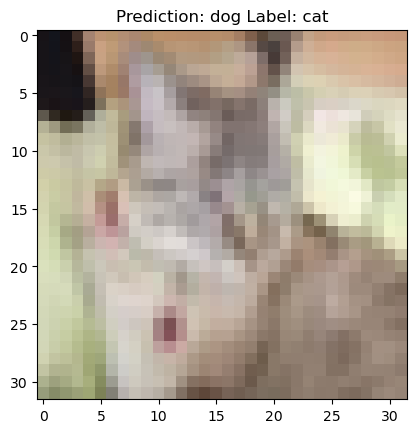

1/1 [==============================] - 0s 35ms/step


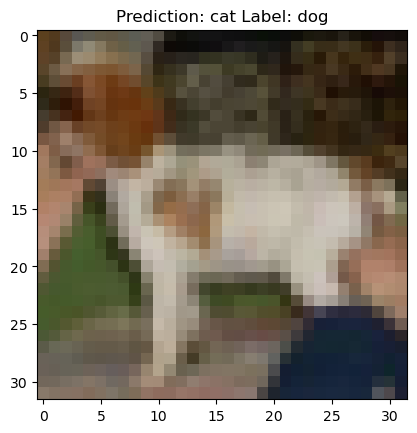

1/1 [==============================] - 0s 26ms/step


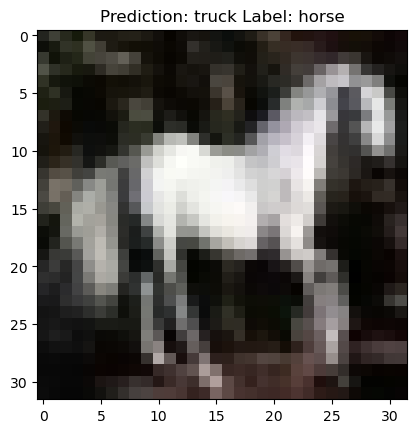

1/1 [==============================] - 0s 36ms/step


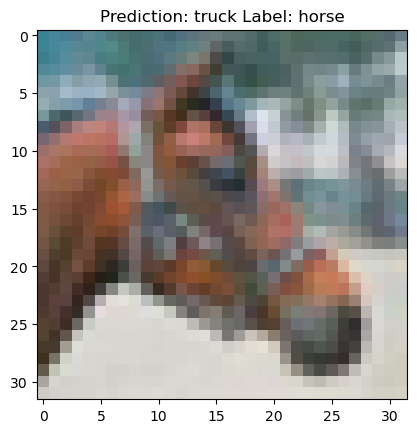

1/1 [==============================] - 0s 25ms/step


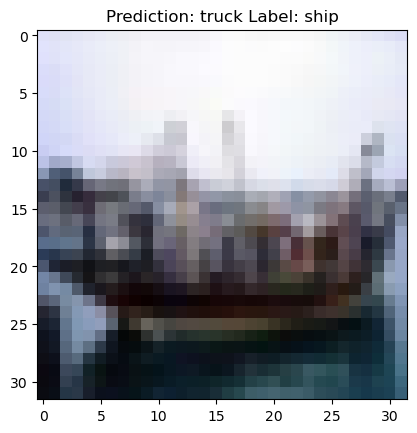

1/1 [==============================] - 0s 29ms/step


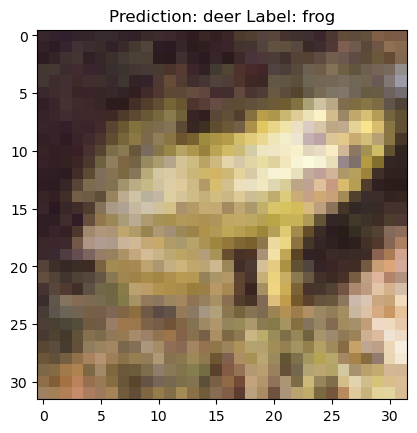

1/1 [==============================] - 0s 22ms/step


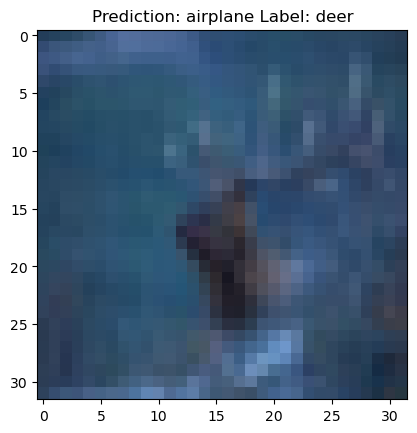

1/1 [==============================] - 0s 28ms/step


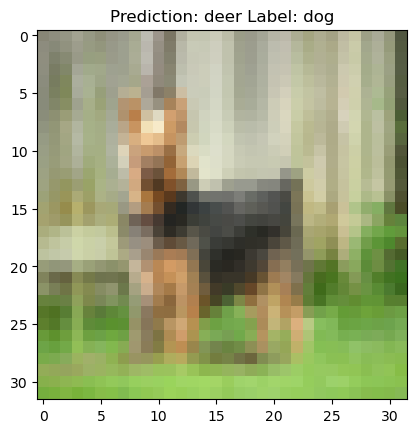

1/1 [==============================] - 0s 25ms/step


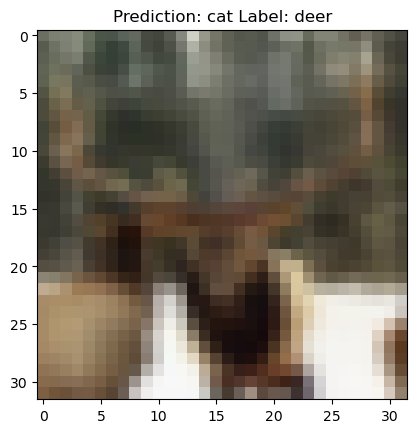

1/1 [==============================] - 0s 26ms/step


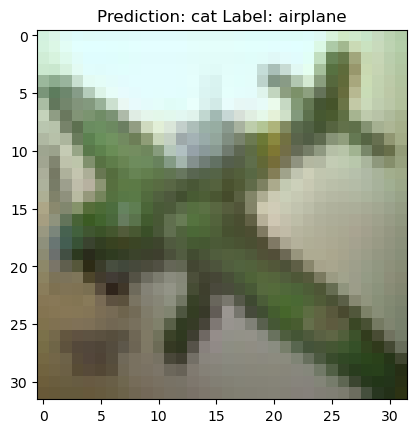

1/1 [==============================] - 0s 24ms/step


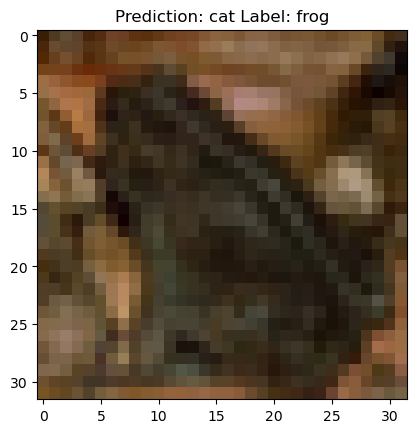

1/1 [==============================] - 0s 25ms/step


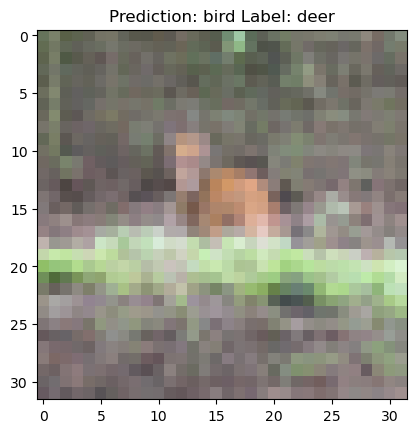

1/1 [==============================] - 0s 25ms/step


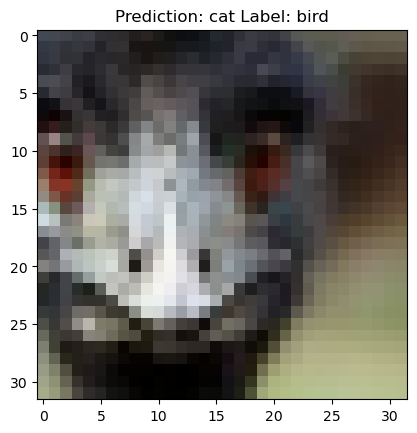

1/1 [==============================] - 0s 26ms/step


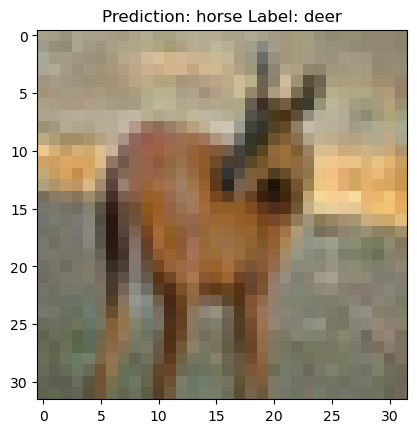

1/1 [==============================] - 0s 25ms/step


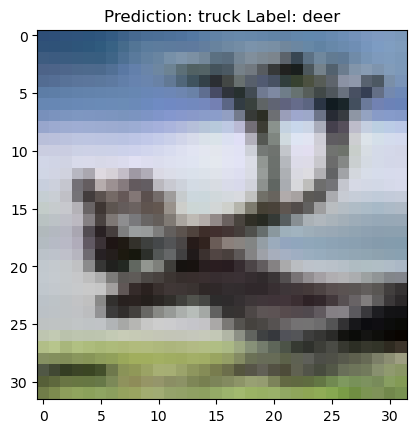

1/1 [==============================] - 0s 23ms/step


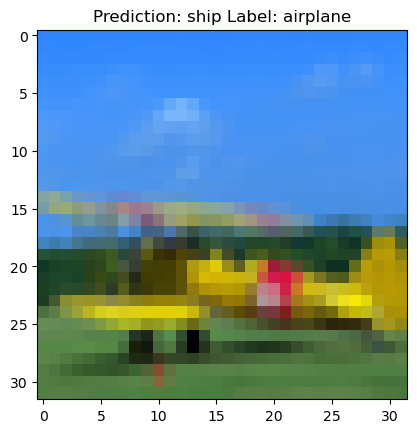

1/1 [==============================] - 0s 24ms/step


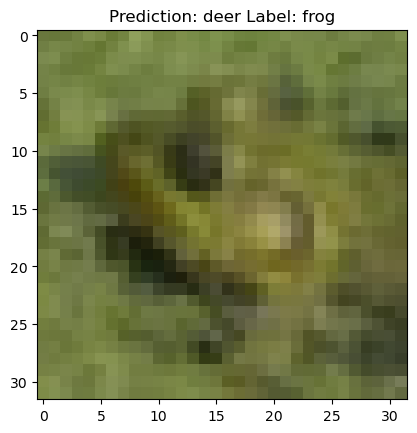

1/1 [==============================] - 0s 28ms/step


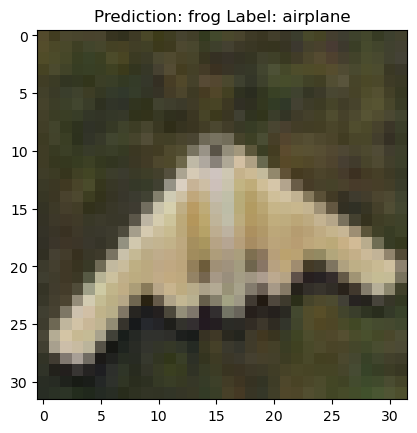

1/1 [==============================] - 0s 28ms/step


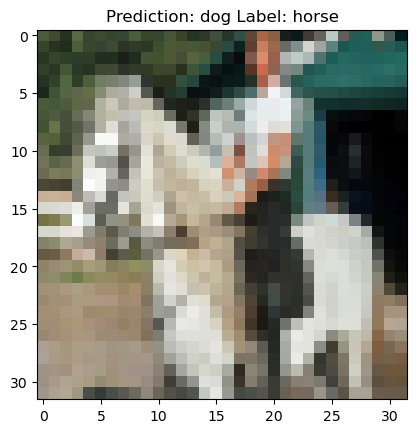

1/1 [==============================] - 0s 25ms/step


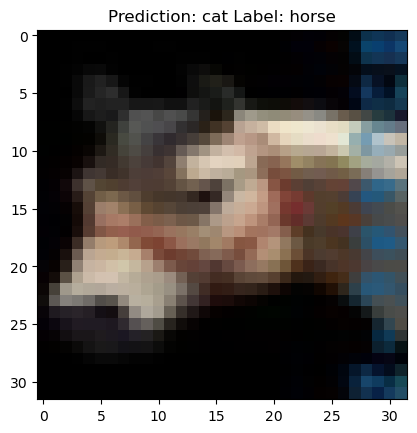

1/1 [==============================] - 0s 27ms/step


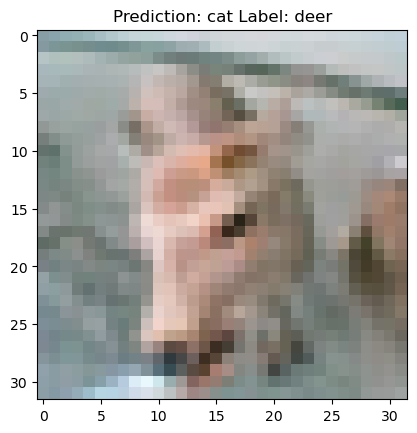

1/1 [==============================] - 0s 25ms/step


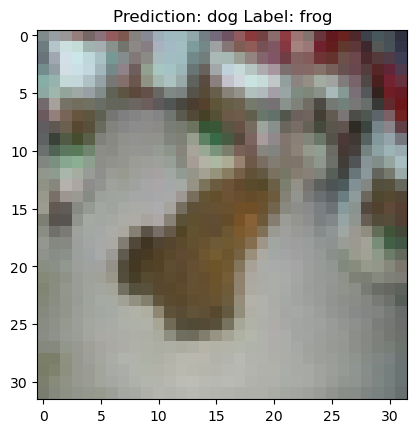

1/1 [==============================] - 0s 22ms/step


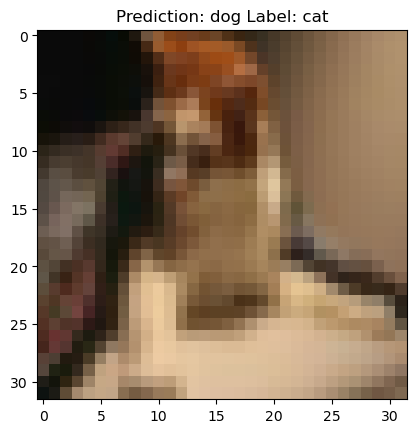

1/1 [==============================] - 0s 27ms/step


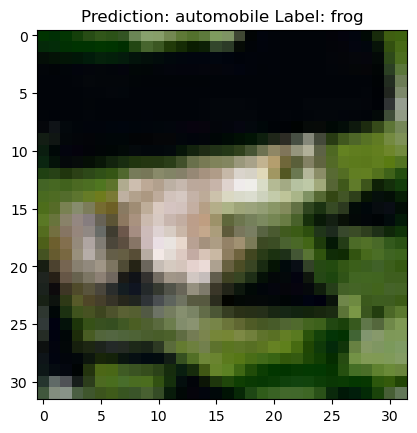

1/1 [==============================] - 0s 26ms/step


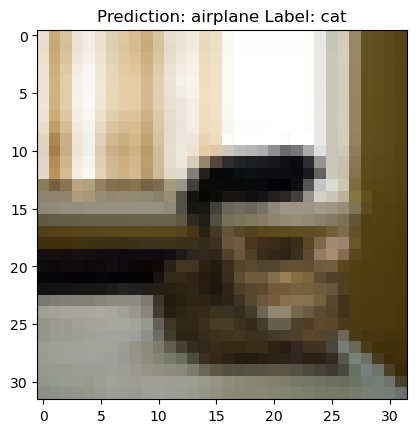

1/1 [==============================] - 0s 25ms/step


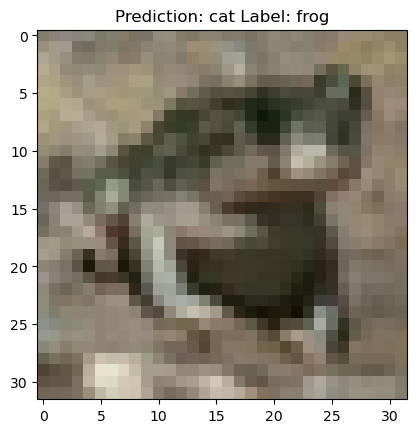

1/1 [==============================] - 0s 24ms/step


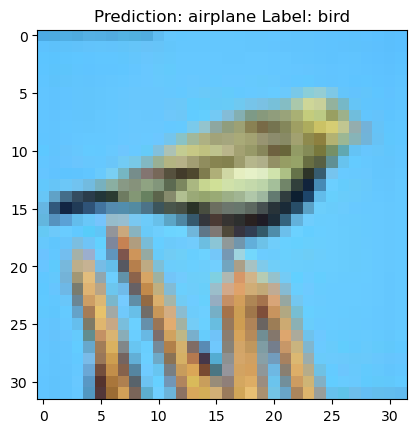

1/1 [==============================] - 0s 26ms/step


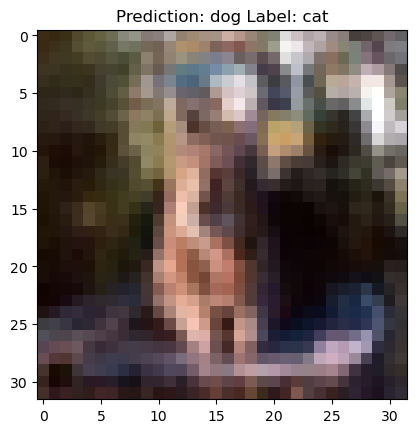

1/1 [==============================] - 0s 26ms/step


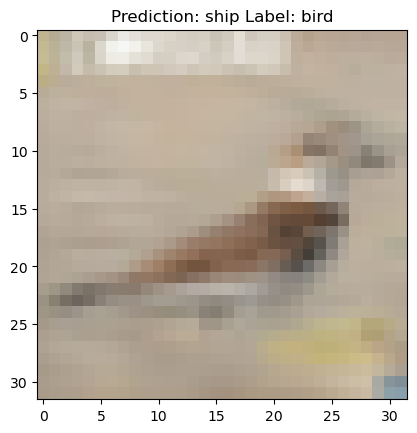

1/1 [==============================] - 0s 27ms/step


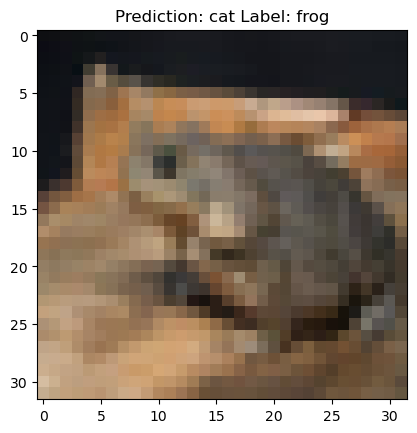

1/1 [==============================] - 0s 23ms/step


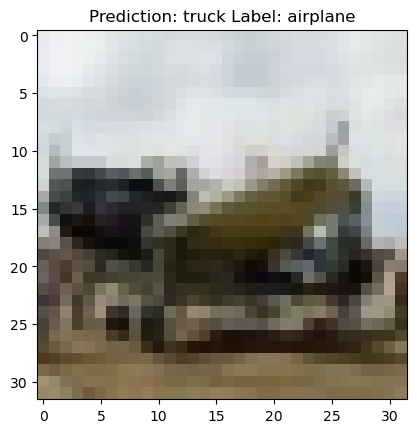

1/1 [==============================] - 0s 26ms/step


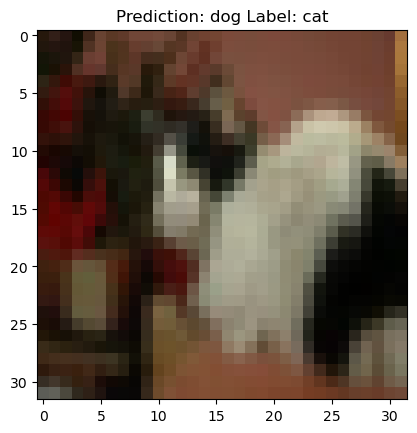

1/1 [==============================] - 0s 29ms/step


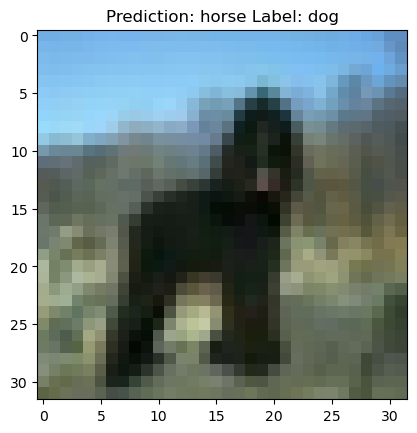

1/1 [==============================] - 0s 26ms/step


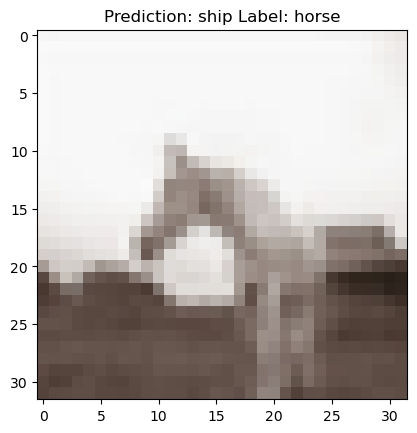

1/1 [==============================] - 0s 24ms/step


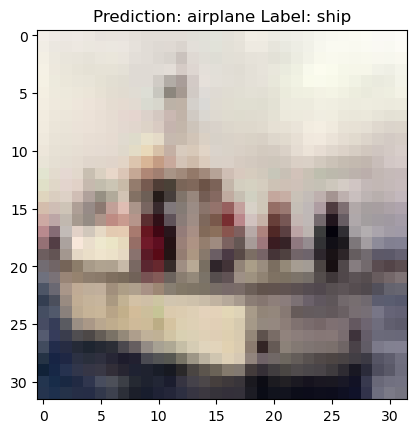

1/1 [==============================] - 0s 25ms/step


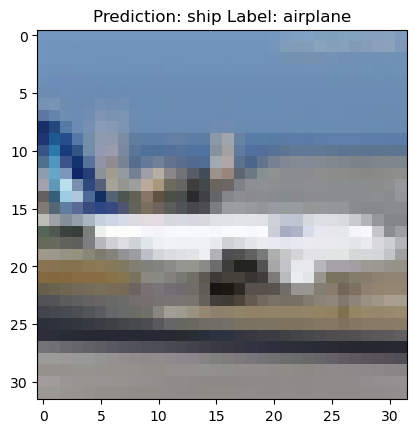

1/1 [==============================] - 0s 23ms/step


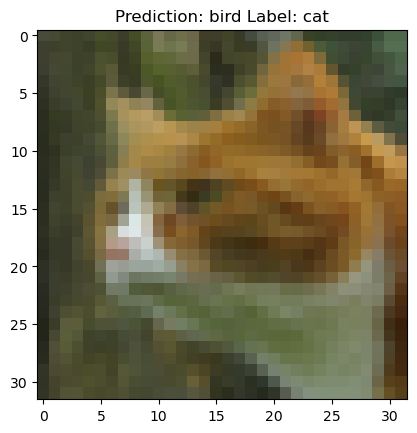

1/1 [==============================] - 0s 25ms/step


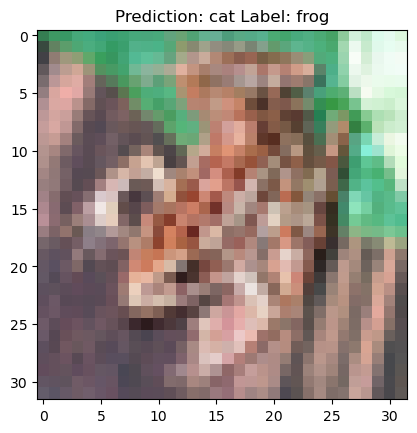

1/1 [==============================] - 0s 28ms/step


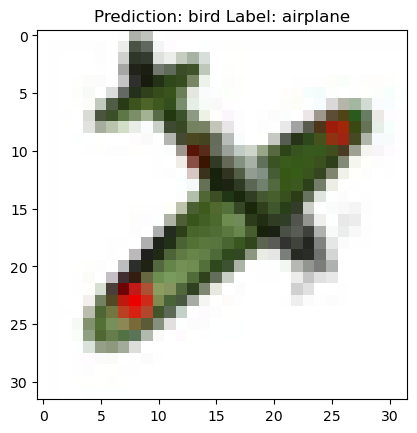

1/1 [==============================] - 0s 25ms/step


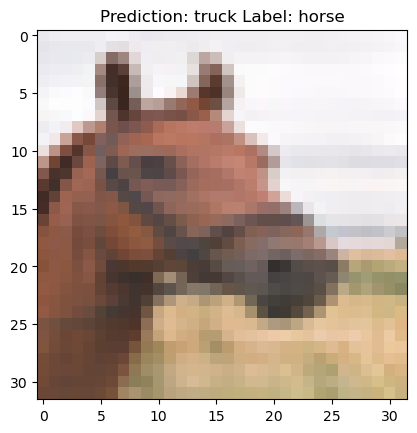

In [27]:
for x in range(100):
    test_image = x_test[x,:]
    predicted_cat = model.predict(np.array([test_image])).argmax()
    label = y_test[x].argmax()
    if (predicted_cat != label):
        plt.title('Prediction: %s Label: %s' % (class_names[predicted_cat], class_names[label]))
        plt.imshow(test_image)
        plt.show()

It's still not quite as good as a human visual cortex, but the images that are tripping the CNN up are in general somewhat strange examples of whatever it is that it's trying to classify. You can understand how it got confused on many of them. After all, a stealth fighter doesn't look like any normal plane, for example. We could achieve better accuracy by running it for even more epochs. But, there are also pre-defined CNN topologies that can do an even better job than this one - and we'll discuss those shortly.